
This is the lstm model for forecasting kospi volatility

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
import data_reader as dr


In [2]:
data, source = dr.read('kospi_extended.csv')

Loading data from file /home/changhyun/workspace/cxk858/dataset/kospi_extended.csv...



In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2456 entries, 0 to 2461
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date                 2456 non-null   object 
 1   Open                 2456 non-null   float64
 2   High                 2456 non-null   float64
 3   Low                  2456 non-null   float64
 4   Close                2456 non-null   float64
 5   Adj Close            2456 non-null   float64
 6   Volume               2456 non-null   float64
 7   Daily_trading_range  2456 non-null   float64
 8   Log_Volume_change    2455 non-null   float64
 9   Daily_return         2455 non-null   float64
 10  Daily_log_return     2455 non-null   float64
 11  Target               2434 non-null   float64
dtypes: float64(11), object(1)
memory usage: 249.4+ KB


In [4]:
data = data.drop(['Date', 'Adj Close', 'Open', 'High', 'Close', 'Volume', 'Low','Daily_return'], axis=1)

In [5]:
x_values = data.iloc[22:, :-1]
y_values = data[['Target']]
y_values = y_values.iloc[22:]

In [6]:
x_values.info()
y_values.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2434 entries, 22 to 2461
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Daily_trading_range  2434 non-null   float64
 1   Log_Volume_change    2434 non-null   float64
 2   Daily_log_return     2434 non-null   float64
dtypes: float64(3)
memory usage: 76.1 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 2434 entries, 22 to 2461
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Target  2434 non-null   float64
dtypes: float64(1)
memory usage: 38.0 KB


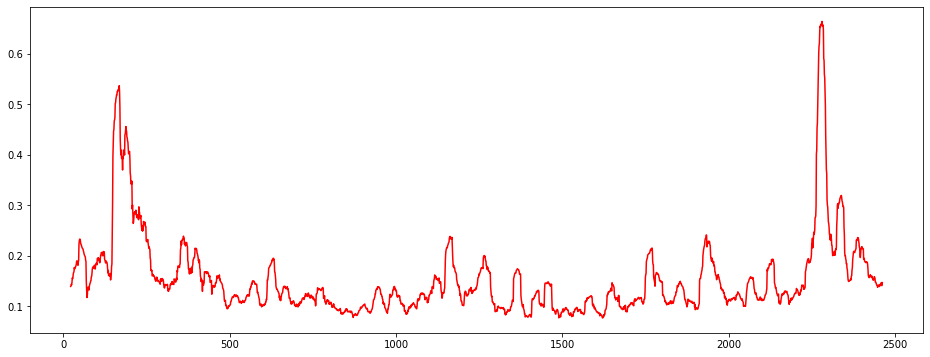

In [7]:
plt.figure(1, figsize=(16,6))
plt.plot(data['Target'], color='red')

In [8]:
scaler = MinMaxScaler()
scaled_x = scaler.fit_transform(x_values)
scaled_y = scaler.fit_transform(y_values)

In [9]:

y_values

,Target
22,0.139579
23,0.140232
24,0.144005
25,0.142697
26,0.148160
...,...
2457,0.146351
2458,0.146712
2459,0.141543
2460,0.141185


In [10]:
split = int(len(x_values)*0.8)

In [11]:
window = 22
trainX = scaled_x[:split]
testX = scaled_x[split:]
trainY = scaled_y[:split]
testY = scaled_y[split:]


In [12]:
Xtrain = []
ytrain = []
Xtest = []
ytest = []

for i in range(window, len(trainX)):
    Xtrain.append(trainX[i-window:i, :trainX.shape[1]])
    ytrain.append(trainY[i])
for i in range(window, len(testX)):
    Xtest.append(testX[i-window:i, :testX.shape[1]])
    ytest.append(testY[i])

In [13]:
Xtrain, ytrain = (np.array(Xtrain), np.array(ytrain))
Xtrain = np.reshape(Xtrain, (Xtrain.shape[0], Xtrain.shape[1], Xtrain.shape[2]))

Xtest, ytest = (np.array(Xtest), np.array(ytest))
Xtest = np.reshape(Xtest, (Xtest.shape[0], Xtest.shape[1], Xtest.shape[2]))

In [14]:

print(Xtrain.shape)
print(ytrain.shape)
print("-----")
print(Xtest.shape)
print(ytest.shape)

(1925, 22, 3)
(1925, 1)
-----
(465, 22, 3)
(465, 1)


In [15]:
print(Xtrain)

[[[0.11634641 0.50094255 0.54262355]
  [0.11425435 0.50791866 0.48106787]
  [0.19185535 0.51370147 0.4462707 ]
  ...
  [0.12295043 0.47444937 0.44316247]
  [0.15162387 0.52118123 0.56258442]
  [0.11117269 0.50634123 0.53029076]]

 [[0.11425435 0.50791866 0.48106787]
  [0.19185535 0.51370147 0.4462707 ]
  [0.16296089 0.49505412 0.40765993]
  ...
  [0.15162387 0.52118123 0.56258442]
  [0.11117269 0.50634123 0.53029076]
  [0.12344557 0.49329492 0.45646498]]

 [[0.19185535 0.51370147 0.4462707 ]
  [0.16296089 0.49505412 0.40765993]
  [0.22559231 0.50525842 0.42282961]
  ...
  [0.11117269 0.50634123 0.53029076]
  [0.12344557 0.49329492 0.45646498]
  [0.09036901 0.49468123 0.43742257]]

 ...

 [[0.09950379 0.50498166 0.61261517]
  [0.10198147 0.51860847 0.46649688]
  [0.08893735 0.49961317 0.47879935]
  ...
  [0.24336809 0.49456064 0.42510235]
  [0.09966974 0.53132158 0.46730555]
  [0.12146436 0.49794526 0.56372824]]

 [[0.10198147 0.51860847 0.46649688]
  [0.08893735 0.49961317 0.47879935]


In [16]:
print(ytrain)

[[0.17771977]
 [0.18901978]
 [0.19486077]
 ...
 [0.13015753]
 [0.12768281]
 [0.1206396 ]]


In [17]:
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error
from tensorflow import keras

In [36]:
model = Sequential()
model.add(LSTM(units=32, return_sequences=False, input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
# model.add(Dropout(0.3))
# model.add(LSTM(units=32, return_sequences=False))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(Xtrain, ytrain, batch_size=16, epochs=20, validation_split=0.2, shuffle=False)

Epoch 1/20
97/97 [==============================] - 3s 14ms/step - loss: 0.0300 - val_loss: 0.0049

In [30]:
# previous_model = keras.models.load_model('models/multi_layer_lstm_model')

In [37]:
forecast = model.predict(Xtest)

In [38]:
rev_forecast = scaler.inverse_transform(forecast)
rev_ytest = scaler.inverse_transform(ytest)

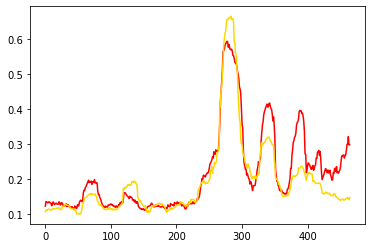

In [39]:
plt.plot(rev_forecast, color='red')
plt.plot(rev_ytest, color='gold')
plt.savefig("images/single_layer_model_pred.png")

plt.show()

In [40]:
testScore = mean_squared_error(rev_ytest, rev_forecast)
print("test Score: {score} MSE".format(score=testScore))
root_testScore = mean_squared_error(rev_ytest, rev_forecast, squared=False)
print("test Score: {score} RMSE".format(score=root_testScore))
mape = mean_absolute_percentage_error(rev_ytest, rev_forecast)
print("test Score: {score} MAPE".format(score=mape))

test Score: 0.002752053248154155 MSE
test Score: 0.052460015708672404 RMSE
test Score: 0.1904512895644694 MAPE


In [275]:
# model.save("models/single_layer_lstm_model")

INFO:tensorflow:Assets written to: models/single_layer_lstm_model/assets


INFO:tensorflow:Assets written to: models/single_layer_lstm_model/assets


## Experiment settings

Dataset: KOSPI index from Jan, 2011 to Dec, 2020\
Included data in default: Daily log return, Daily trading range, Log volume change\
Additional data for hybrid: Next prediction by GARCH and GJR-GARCH

- Loss function: mean_squared_error
- Optimizer: Adam
- epochs: 20
- batch_size: 16

## Experiment results


- Single-layer lstm model (32 units)
    * Training error: 0.0042, Validation error: 0.0031
    * MSE: 0.0032
    * RMSE: 0.0568
    * MAPE 0.1912

![title](images/single_layer_model_pred.png)

- Multi-layer lstm model (32 units, dropout 0.3, 32 units)
    * Training error: 0.0045, Validation error: 0.0024
    * MSE: 0.0023
    * RMSE 0.0484
    * MAPE: 0.1701
    
![title](images/multi_layer_model_pred.png)

- Single-layer hybrid model (32 units)
    * Training error: 0.0016, Validation error: 0.0001
    * MSE: 0.0007
    * RMSE: 0.0269
    * MAPE: 0.0924

![title](images/single_layer_hybrid_pred.png)

- Multi-layer hybrid model (32 units, dropout 0.3, 32 units)
    * Training error: 0.0024, Validation error: 0.0001
    * MSE: 0.0008
    * RMSE: 0.0274
    * MAPE: 0.0935
    
![title](images/multi_layer_hybrid_pred.png)